Classification Report:
Class Labels: ['Dementia', 'HC', 'MCI']
y_test unique values: [2 1 0]
y_pred unique values: [2 1 0]
              precision    recall  f1-score   support

    Dementia       0.75      0.75      0.75         4
          HC       0.93      0.93      0.93        15
         MCI       0.85      0.85      0.85        13

    accuracy                           0.88        32
   macro avg       0.84      0.84      0.84        32
weighted avg       0.88      0.88      0.88        32



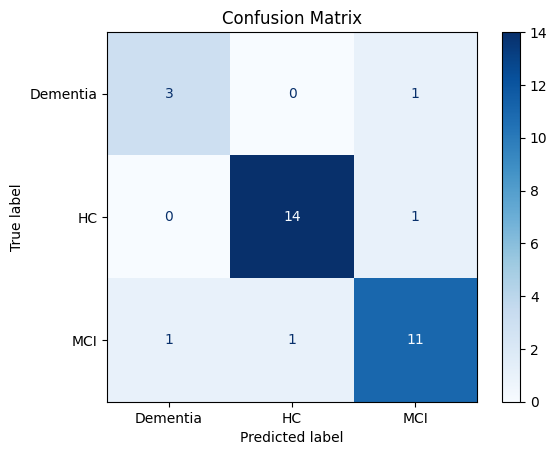

Top Features by Importance:
             Feature  Importance
1     Converted-MMSE    0.436643
5       unique_words    0.112764
0                Age    0.109571
3      stutter_words    0.098165
2         word_count    0.083410
6  interrupter_count    0.082156
4   meaningful_words    0.077291


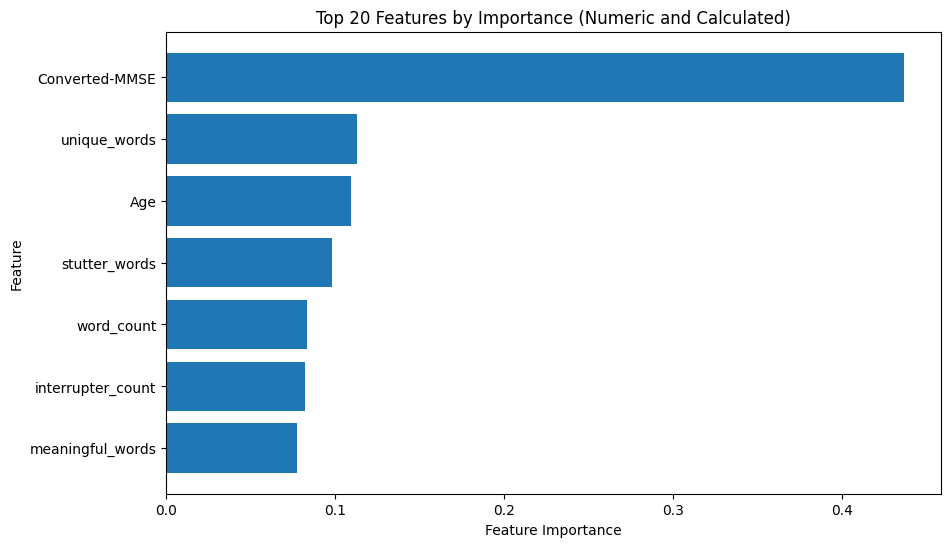

In [1]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sympy import gamma
from xgboost import XGBClassifier



# Helper function to extract data from text files
def load_data(file_pattern, base_path):
    data = []
    record_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids


# Helper function to load labels
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df.set_index('Record-ID')[['Class', 'Age', 'Converted-MMSE']]  # Removed 'Gender'


# Feature engineering: Calculate text and timing features
def count_interrupters_and_clean_text(text):
    interrupter_count = len(re.findall(r'\(.*?\)', text))  # Count interruptions in parentheses
    cleaned_text = re.sub(r'\(.*?\)', '', text)  # Remove parentheses content
    return interrupter_count, cleaned_text


def find_repetitions_and_timing(text):
    interrupter_count, cleaned_text = count_interrupters_and_clean_text(text)
    words = re.findall(r'\b\w+\b', cleaned_text)
    stutter_words = len(re.findall(r'\b(er|um|oh|ah|mm)\b', cleaned_text))
    meaningful_words = len(words) - stutter_words
    unique_words = len(set(words))
    word_count = len(words)
    return {
        'word_count': word_count,
        'stutter_words': stutter_words,
        'meaningful_words': meaningful_words,
        'unique_words': unique_words,
        'interrupter_count': interrupter_count,
    }


def extract_features(texts):
    return pd.DataFrame([find_repetitions_and_timing(text) for text in texts])


# Load and combine data
base_path = "../process/PROCESS-V1/"
file_pattern = r"Process-rec-\d+__CTD\.txt"
data, record_ids = load_data(file_pattern, base_path)

label_file = "../process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels = load_labels(label_file)

combined_data = []
for text, record_id in zip(data, record_ids):
    if record_id in labels.index:
        row = labels.loc[record_id]
        combined_data.append({
            'Record-ID': record_id,
            'Text': text,
            'Class': row['Class'],
            'Age': row['Age'],
            'Converted-MMSE': row['Converted-MMSE'],  # Removed 'Gender'
        })

df = pd.DataFrame(combined_data)

df['Class'] = df['Class'].astype('category').cat.codes  # Encode Class as labels (target)
df.dropna(inplace=True)
# Entferne 'Process-rec-071'
df = df[df['Record-ID'] != 'Process-rec-071'].reset_index(drop=True)

X_text = df['Text']
X_numeric = df[['Age', 'Converted-MMSE']]  # Removed 'Gender'
y = df['Class']

# Split data
X_train_text, X_test_text, X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

# Extract text features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_text_features = tfidf_vectorizer.fit_transform(X_train_text)
X_test_text_features = tfidf_vectorizer.transform(X_test_text)

# Extract calculated features
X_train_calculated_features = extract_features(X_train_text).reset_index(drop=True)
X_test_calculated_features = extract_features(X_test_text).reset_index(drop=True)

# Combine TF-IDF features, calculated features, and numeric features
X_train_combined = pd.concat([
    pd.DataFrame(X_train_text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out()),
    X_train_calculated_features,
    X_train_numeric.reset_index(drop=True)
], axis=1)

X_test_combined = pd.concat([
    pd.DataFrame(X_test_text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out()),
    X_test_calculated_features,
    X_test_numeric.reset_index(drop=True)
], axis=1)

# Combine numeric and calculated features
numeric_features = ['Age', 'Converted-MMSE']  # Removed 'Gender'
calculated_features = list(X_train_calculated_features.columns)
all_numeric_features = numeric_features + calculated_features

# Update ColumnTransformer to include calculated features
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), all_numeric_features),
    ]
)

# Pipeline aktualisieren, um XGBClassifier zu verwenden
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, n_estimators=200, colsample_bytree=0.8, subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0)),
])
#Beste Parameter:
#{'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


# Fit the model
pipeline.fit(X_train_combined, y_train)

# Predict on test data
y_pred = pipeline.predict(X_test_combined)

# Classification report
class_labels = labels['Class'].astype('category').cat.categories.tolist()
print("Classification Report:")
print("Class Labels:", class_labels)
print("y_test unique values:", pd.Series(y_test).unique())
print("y_pred unique values:", pd.Series(y_pred).unique())
print(classification_report(y_test, y_pred, target_names=class_labels))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Extract feature importances from the trained model
trained_model = pipeline.named_steps['classifier']
feature_importances = trained_model.feature_importances_

# Ensure lengths match
if len(all_numeric_features) != len(feature_importances):
    raise ValueError(f"Feature mismatch: {len(all_numeric_features)} features, but {len(feature_importances)} importances.")

# Create DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': all_numeric_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Output top features
print("Top Features by Importance:")
print(feature_importances_df.head(20))

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'][:20], feature_importances_df['Importance'][:20])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Features by Importance (Numeric and Calculated)")
plt.show()
